# Automatic Device Selection

The Auto Device (or AUTO in short) selects the most suitable device from the available compute devices by considering the network precision, power efficiency and processing capability. The network precision (if the network is quantized or not) is the first consideration to filter out the devices that cannot run the network efficiently.

Next, the dedicated accelerator devices are preferred, e.g., discrete GPU, integrated GPU, or VPU. CPU is used as the default “fallback device”. Please note that AUTO does this selection only once at the network load time. 

When choosing the accelerator device like GPUs, loading the network to these devices may take long time. To address this challenge for application that requires fast initial inference response the AUTO starts inferencing immediately on the CPU and then transparently shifts inferencing to the GPU once ready, dramatically reducing time to first inference.

![Auto Device Selection logic](data/auto_device_selection.png "Auto Device Selection")

The following demostrations use the [resnet-50-tf](https://docs.openvino.ai/latest/omz_models_model_resnet_50_tf.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). resnet-50-tf is a TensorFlow* implementation of ResNet-50 - an image classification model pre-trained on the ImageNet dataset. Originally redistributed in Saved model format, converted to frozen graph using tf.graph_util module. For details see [paper](https://arxiv.org/abs/1512.03385), [repository](https://github.com/tensorflow/models/tree/v2.2.0/official/r1/resnet).

Please follow the [104-model-tools](../104-model-tools/README.md) to download resnet-50-tf and convert (--precisions FP16), copy the results (resnet-50-tf.bin and resnet-50-tf.xml) to notebooks\106-auto-device\model\ folder

## compile_model with AUTO device
### Default behavior of compile_model without device_name
By default compile_model will select AUTO as device_name if it is not specificed.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core, CompiledModel

ie = Core()

model = ie.read_model(model="model/resnet-50-tf.xml")
compiled_model = ie.compile_model(model=model, config={"LOG_LEVEL":"LOG_INFO"})

if isinstance(compiled_model, CompiledModel):
    print("Compile model without device_name successfully.")

Compile model without device_name successfully.


### compile_model with AUTO as device name

In [3]:
compiled_model = ie.compile_model(model=model, device_name="AUTO")

if isinstance(compiled_model, CompiledModel):
    print("Compile model with AUTO successfully.")

Compile model with AUTO successfully.


## First inference latency benifit with AUTO
One of the key performance benefits of AUTO is on first inference latency (FIL = compile model time + fist inference execution time). Directly using CPU device would produce the shortest first inference latency as the OpenVINO graph representations can really quickly be JIT-compiled to CPU. The challenge is with the GPU. Since the OpenCL complication of graph to GPU-optimized kernels takes a few seconds to complete for this platform. If AUTO selects GPU as the device, this initialization time may be intolerable to some applications, which is the reason for AUTO to transparently use the CPU as the first inference device until GPU is ready. 
### Load an Image

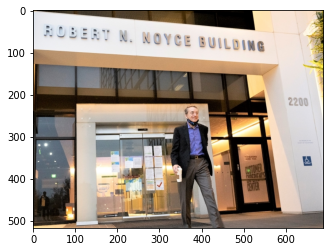

In [6]:
input_layer_ir = next(iter(compiled_model.inputs))

# Text detection models expects image in BGR format
image = cv2.imread("data/intel_rnb.jpg")

# N,C,H,W = batch size, number of channels, height, width
N, C, H, W = input_layer_ir.shape

# Resize image to meet network expected input sizes
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

### compile_model with GPU Device and do first inference

In [12]:
import time
# Start to compile model, time point 1

# Compile model
gpu_load_start_time = time.perf_counter()
compiled_model = ie.compile_model(model=model, device_name="GPU") # load to GPU

input_layer_ir = next(iter(compiled_model.inputs))

# Create inference request
request = compiled_model.create_infer_request()
request.infer({input_layer_ir.any_name: input_image})

# Get 1st inference, time point 2
gpu_fil_end_time = time.perf_counter()
gpu_fil_span = gpu_fil_end_time - gpu_load_start_time
print(f"Loaded model to GPU and get first inference in {gpu_fil_end_time-gpu_load_start_time:.2f} seconds.")

Loaded model to GPU and get first inference in 4.14 seconds.


### compile_model with AUTO Device and do first inference

In [13]:
# Start to compile model, time point 1

# Compile model
auto_load_start_time = time.perf_counter()
compiled_model = ie.compile_model(model=model) # device_name is AUTO by default
input_layer_ir = next(iter(compiled_model.inputs))

# Create inference request
request = compiled_model.create_infer_request()
request.infer({input_layer_ir.any_name: input_image})

# Get 1st inference, time point 2
auto_fil_end_time = time.perf_counter()
auto_fil_span = auto_fil_end_time - auto_load_start_time
print(f"Loaded model to AUTO and get first inference in {auto_fil_end_time-auto_load_start_time:.2f} seconds.")

Loaded model to AUTO and get first inference in 0.10 seconds.


### First inference latency benefit 

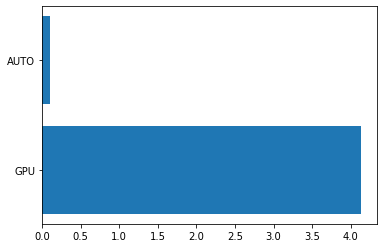

In [15]:
# Output the latency difference
device_list = ["GPU", "AUTO"]
load_and_fil_list = [gpu_fil_span, auto_fil_span]
plt.barh(range(len(load_and_fil_list)), load_and_fil_list, tick_label=device_list)
plt.show()


## Performance hint
The next highlight is the differentiation of performance hint with AUTO. By specifying LATENCY hint or THROUGHTPUT hint, AUTO demonstrate significant performance results towards the desired metric. THROUGHTPUT hint delivers much higher frame per second (FPS) performance than LATENCY hint. In contrast, the LATENCY hint delivers much lower latency than THROUGHTPUT hint. Notice that the hints do not require low-level device-specific settings, and are also completely portable between the devices, which allows the AUTO just to expedite the hint value directly to the selected device.

### compile_model with THROUGHTPUT hint

Loop for the inference and output the FPS/Latency for each n sencods

In [60]:
from openvino.runtime import AsyncInferQueue, InferRequest

# output period (seconds)
period = 10

end_after_n_periods = 20

compiled_model = ie.compile_model(model=model, device_name="CPU", config={"PERFORMANCE_HINT":"THROUGHPUT"})
latency_list = []
def completion_callback(infer_request: InferRequest, job_id) -> None:
    latency_list.append(request.latency)

infer_queue = AsyncInferQueue(compiled_model, 0) #set 0 will query optimal num by default
infer_queue.set_callback(completion_callback)

start_time = time.perf_counter()
exec_time = time.perf_counter()-start_time
job_id = 0
while exec_time < end_after_n_periods:
    period_start_time = time.perf_counter()
    period_exec_time = time.perf_counter()-period_start_time
    while period_exec_time < period:
        infer_queue.start_async({input_layer_ir.any_name: input_image}, job_id)
        period_exec_time = time.perf_counter()-period_start_time
        job_id+=1
    infer_queue.wait_all()
    duration = time.perf_counter()-period_start_time
    fps = job_id/duration
    job_id = 0
    print("fps:"+str(fps))
    exec_time = time.perf_counter()-start_time




fps:77.39608520407255
fps:78.04409216731877


### compile_model with LATENCY hint

Loop for the inference and output the FPS/Latency for each n sencods

In [ ]:
# output period (seconds), share the same as previous one



### FPS and Latency difference


In [ ]:
# output the difference

